In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV

# For model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [56]:
def load_and_explore_data(file_path):
    """
    Load and perform initial data exploration
    """
    # Load data
    df = pd.read_csv(file_path)
    
    print("1. Basic Dataset Information:")
    print("-" * 50)
    print(f"Shape of dataset: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())

    df.drop(columns=['Series_Title'], inplace=True)
    df.drop(columns=['Overview'], inplace=True)
    df.drop(columns=['Director'], inplace=True)
    df.drop(columns=['Star'], inplace=True)
    df.drop(columns=['Certificate'], inplace=True)

    df['Gross'] = df['Gross'].str.replace(',', '')
    df['Gross'] = df['Gross'].astype('float64')

    df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)
    
    return df

In [57]:
def perform_eda(df):
    print("\n2. Detailed EDA")
    print("-" * 50)
    
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    print("\nNumerical Columns:", numerical_cols.tolist())
    print("Categorical Columns:", categorical_cols.tolist())
    
    # Univariate Analysis
    print("\n2.1 Univariate Analysis")
    print("-" * 30)
    
    # For numerical columns
    print("\nNumerical Columns Summary:")
    print(df[numerical_cols].describe())
    
    # Visualize distributions
    for col in numerical_cols:
        plt.figure(figsize=(10, 4))
        
        # Histogram
        plt.subplot(121)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        
        # Box plot
        plt.subplot(122)
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')
        plt.tight_layout()
        plt.show()
    
    # For categorical columns
    print("\nCategorical Columns Summary:")
    for col in categorical_cols:
        print(f"\n{col} value counts:")
        print(df[col].value_counts())
        print(f"{col} unique values:", df[col].nunique())
        
        # Bar plot
        plt.figure(figsize=(10, 4))
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.show()
    
    # Bivariate Analysis
    print("\n2.2 Bivariate Analysis")
    print("-" * 30)
    
    # Correlation matrix for numerical columns
    if len(numerical_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()
    
    # Chi-square test for categorical columns
    if len(categorical_cols) > 1:
        print("\nChi-square test results for categorical variables:")
        for col1 in categorical_cols:
            for col2 in categorical_cols:
                if col1 < col2:
                    contingency_table = pd.crosstab(df[col1], df[col2])
                    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
                    print(f"{col1} vs {col2}:")
                    print(f"Chi-square statistic: {chi2:.2f}")
                    print(f"p-value: {p_value:.4f}\n")
    
    return numerical_cols, categorical_cols

In [58]:
def preprocess_data(df, numerical_cols, categorical_cols):
    print("\n3. Data Preprocessing")
    print("-" * 50)

    target_column='Gross'
    
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Handle missing values
    print("\n3.1 Handling Missing Values")
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if col in numerical_cols:
                # Fill numerical missing values with median
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
            else:
                # Fill categorical missing values with mode
                df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    # Remove duplicates
    df_processed.drop_duplicates(inplace=True)
    
    # Encode categorical variables
    print("\n3.2 Encoding Categorical Variables")
    label_encoders = {}
    for col in categorical_cols:
        if col != target_column:  # Don't encode target column yet
            label_encoders[col] = LabelEncoder()
            df_processed[col] = label_encoders[col].fit_transform(df_processed[col])
    
    # Prepare features and target
    X = df_processed.drop(columns=['Meta_score','Gross'], axis=1)
    y = df_processed['Meta_score']

    scaler = StandardScaler()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    numerical_cols_present = [col for col in numerical_cols if col in X.columns]
    if numerical_cols_present:
        X_train[numerical_cols_present] = scaler.fit_transform(X_train[numerical_cols_present])
        X_test[numerical_cols_present] = scaler.transform(X_test[numerical_cols_present])
    
    print("\n3.3 Data Split Information:")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, scaler, label_encoders

In [59]:
df = load_and_explore_data("./IMDB_Dataset.csv")

1. Basic Dataset Information:
--------------------------------------------------
Shape of dataset: (650, 12)

First few rows:
               Series_Title  Released_Year Certificate  Runtime  \
0  The Shawshank Redemption           1994           A  142 min   
1             The Godfather           1972           A  175 min   
2           The Dark Knight           2008          UA  152 min   
3    The Godfather: Part II           1974           A  202 min   
4              12 Angry Men           1957           U   96 min   

                  Genre  IMDB_Rating  \
0                 Drama          9.3   
1          Crime, Drama          9.2   
2  Action, Crime, Drama          9.0   
3          Crime, Drama          9.0   
4          Crime, Drama          9.0   

                                            Overview  Meta_score  \
0  Two imprisoned men bond over a number of years...        80.0   
1  An organized crime dynasty's aging patriarch t...       100.0   
2  When the menace known a


2. Detailed EDA
--------------------------------------------------

Numerical Columns: ['Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']
Categorical Columns: ['Genre']

2.1 Univariate Analysis
------------------------------

Numerical Columns Summary:
       Released_Year  IMDB_Rating  Meta_score   No_of_Votes         Gross
count     650.000000   650.000000  516.000000  6.500000e+02  5.340000e+02
mean     1990.650769     8.091692   80.197674  3.225202e+05  7.033044e+07
std        24.836033     0.236549   11.920761  3.768351e+05  1.187986e+08
min      1920.000000     7.800000   33.000000  2.508800e+04  1.305000e+03
25%      1973.000000     7.900000   73.000000  5.734550e+04  2.248331e+06
50%      2000.000000     8.000000   82.000000  1.552450e+05  1.765445e+07
75%      2010.750000     8.200000   89.000000  4.658788e+05  8.917639e+07
max      2020.000000     9.300000  100.000000  2.343110e+06  9.366622e+08


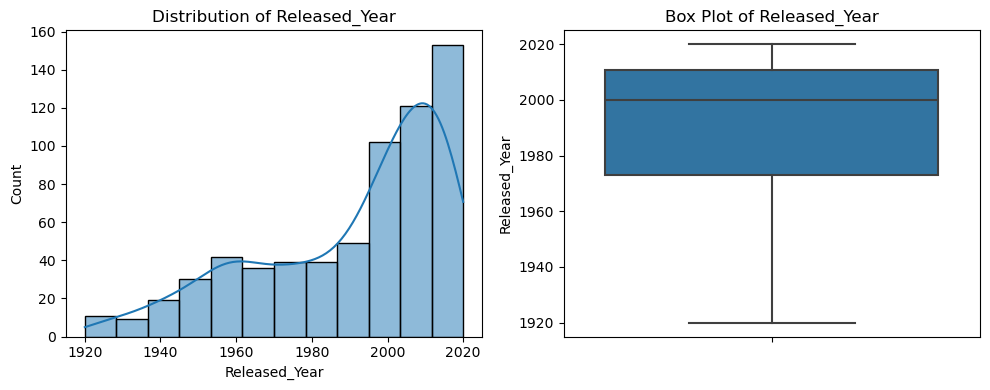

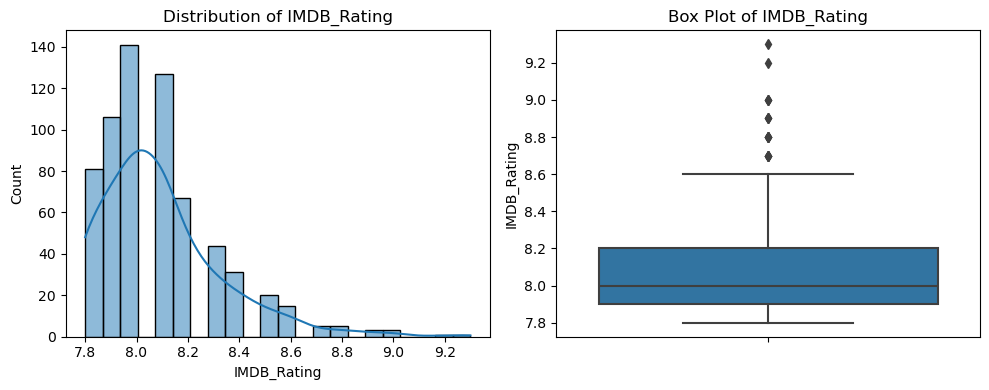

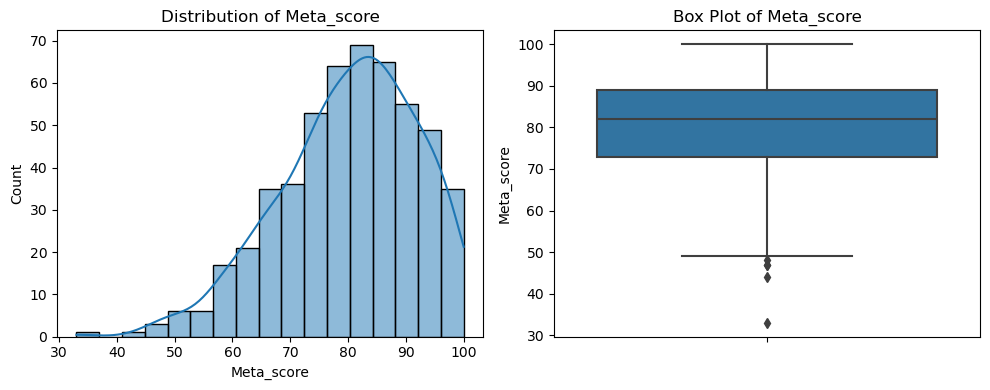

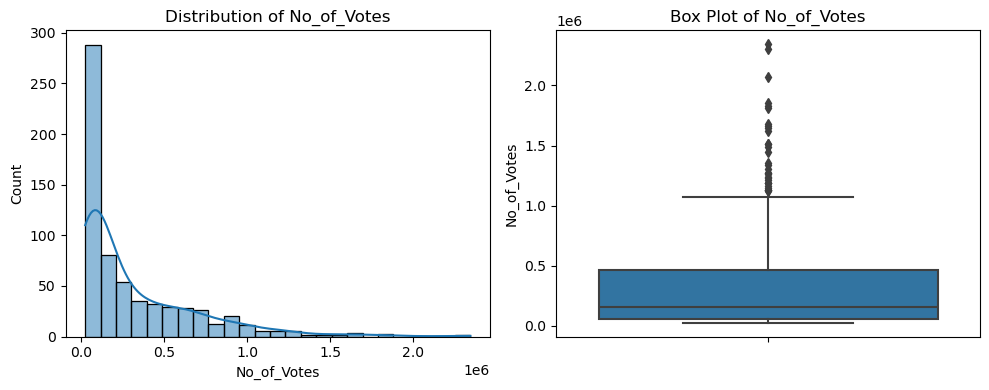

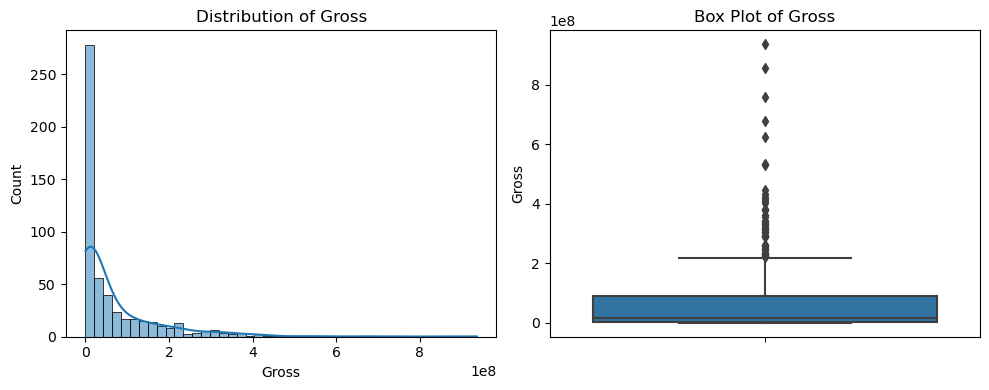


Categorical Columns Summary:

Genre value counts:
Genre
Drama                            57
Drama, Romance                   25
Crime, Drama                     21
Biography, Drama, History        20
Comedy, Drama                    20
                                 ..
Animation, Adventure, Fantasy     1
Comedy, Crime, Sport              1
Comedy, Crime, Romance            1
Adventure, Drama, Musical         1
Adventure, Drama, Romance         1
Name: count, Length: 173, dtype: int64
Genre unique values: 173


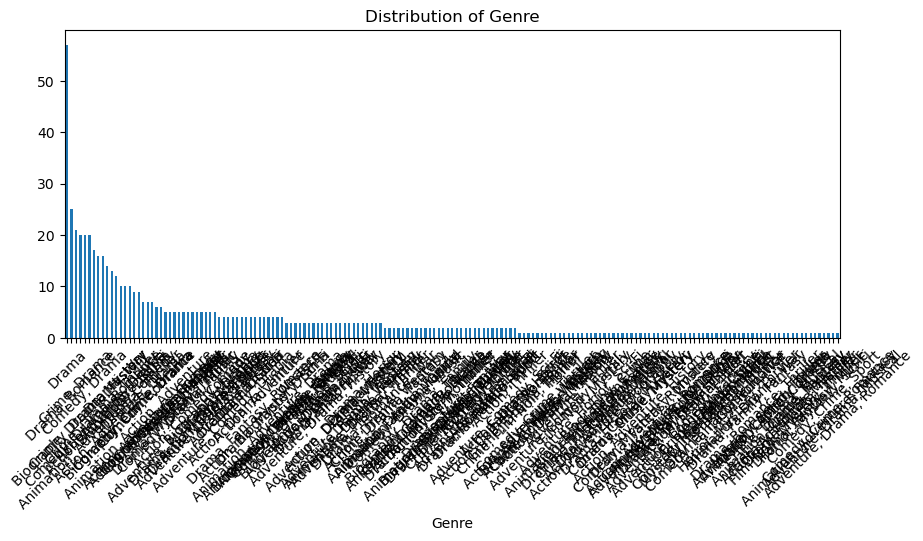


2.2 Bivariate Analysis
------------------------------


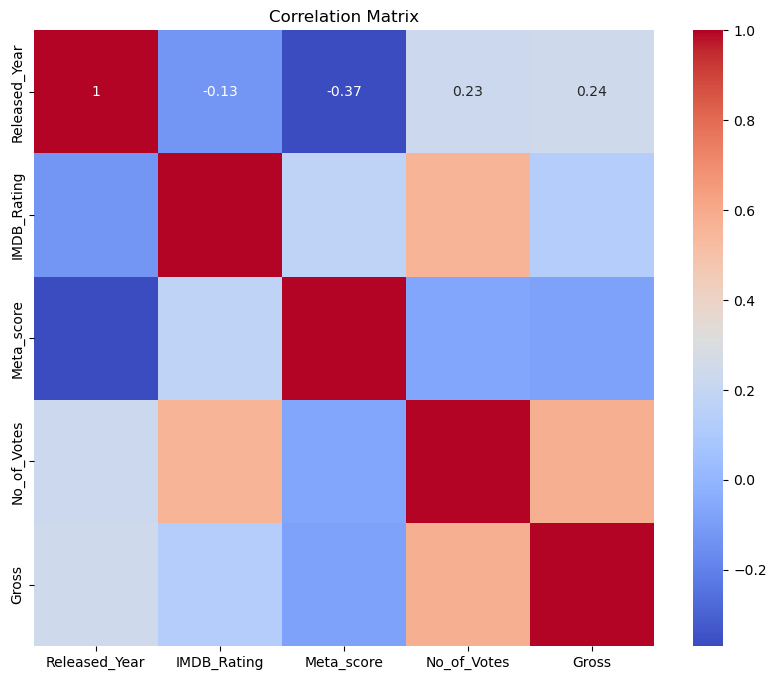

In [60]:
numerical_cols, categorical_cols = perform_eda(df)

In [61]:
X_train, X_test, y_train, y_test, scaler, label_encoders = preprocess_data(df, numerical_cols, categorical_cols)


3. Data Preprocessing
--------------------------------------------------

3.1 Handling Missing Values

3.2 Encoding Categorical Variables

3.3 Data Split Information:
Training set shape: (520, 5)
Testing set shape: (130, 5)


In [62]:
def train_mlp_classifier(X_train, X_test, y_train, y_test, scaler):
    """
    Train and evaluate an MLP classifier with improved parameters for Meta_score prediction
    """
    print("\n4. MLP Training and Evaluation")
    print("-" * 50)
    
    # Convert Meta_score to classification problem using domain-specific thresholds
    def categorize_meta_score(score):
        if score >= 85:  # Outstanding reviews
            return 'High'
        elif score >= 70:  # Generally favorable reviews
            return 'Medium'
        else:  # Mixed or unfavorable reviews
            return 'Low'
    
    # Convert target to categories
    y_train_cat = pd.Series(y_train).apply(categorize_meta_score)
    y_test_cat = pd.Series(y_test).apply(categorize_meta_score)
    
    # Label encode the target
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_cat)
    y_test_encoded = le.transform(y_test_cat)
    
    # Define parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(100,), (100, 50), (150, 75)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01],
        'batch_size': [32, 64]
    }
    
    # Initialize base MLP
    base_mlp = MLPClassifier(
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2
    )
    
    # Perform grid search
    print("\n4.1 Performing Grid Search for Optimal Parameters...")
    grid_search = GridSearchCV(
        base_mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train_encoded)
    
    # Get best model
    mlp = grid_search.best_estimator_
    print("\nBest parameters:", grid_search.best_params_)
    
    # Make predictions
    y_pred = mlp.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f"\n4.2 Model Accuracy: {accuracy:.4f}")
    
    # Plot confusion matrix
    print("\n4.3 Generating Confusion Matrix...")
    plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)
    
    # Print classification report
    print("\n4.4 Classification Report:")
    print(classification_report(y_test_encoded, y_pred, 
                              target_names=le.classes_))
    
    # Plot learning curves
    print("\n4.5 Generating Learning Curve...")
    plot_learning_curve(mlp, X_train, y_train_encoded)
    
    # Plot feature importance
    print("\n4.6 Analyzing Feature Importance...")
    plot_feature_importance(mlp, X_train.columns)
    
    return mlp, le

def plot_learning_curve(estimator, X, y):
    """Plot learning curve to show model's performance with increasing data"""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', 
                xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title('Confusion Matrix (%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_feature_importance(mlp, feature_names):
    """Plot feature importance based on neural network weights"""
    importance = np.abs(mlp.coefs_[0]).mean(axis=1)
    importance = importance / importance.sum()
    
    feat_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feat_importance)
    plt.title('Feature Importance')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

# Usage example with your existing preprocessing:
def run_mlp_analysis(df):
    """Run complete MLP analysis pipeline"""
    # Modify df to use Meta_score as target
    df_meta = df.copy()
    df_meta['Gross_Earing']=df_meta['Gross']
    df_meta['Gross'] = df_meta['Meta_score']
    
    # Run existing preprocessing
    numerical_cols, categorical_cols = perform_eda(df_meta)
    X_train, X_test, y_train, y_test, scaler, label_encoders = preprocess_data(
        df_meta, numerical_cols, categorical_cols)
    
    # Train and evaluate MLP
    mlp, target_encoder = train_mlp_classifier(X_train, X_test, y_train, y_test, scaler)
    
    return mlp, target_encoder, scaler, label_encoders


2. Detailed EDA
--------------------------------------------------

Numerical Columns: ['Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross', 'Gross_Earing']
Categorical Columns: ['Genre']

2.1 Univariate Analysis
------------------------------

Numerical Columns Summary:
       Released_Year  IMDB_Rating  Meta_score   No_of_Votes       Gross  \
count     650.000000   650.000000  516.000000  6.500000e+02  516.000000   
mean     1990.650769     8.091692   80.197674  3.225202e+05   80.197674   
std        24.836033     0.236549   11.920761  3.768351e+05   11.920761   
min      1920.000000     7.800000   33.000000  2.508800e+04   33.000000   
25%      1973.000000     7.900000   73.000000  5.734550e+04   73.000000   
50%      2000.000000     8.000000   82.000000  1.552450e+05   82.000000   
75%      2010.750000     8.200000   89.000000  4.658788e+05   89.000000   
max      2020.000000     9.300000  100.000000  2.343110e+06  100.000000   

       Gross_Earing  
count  5.340

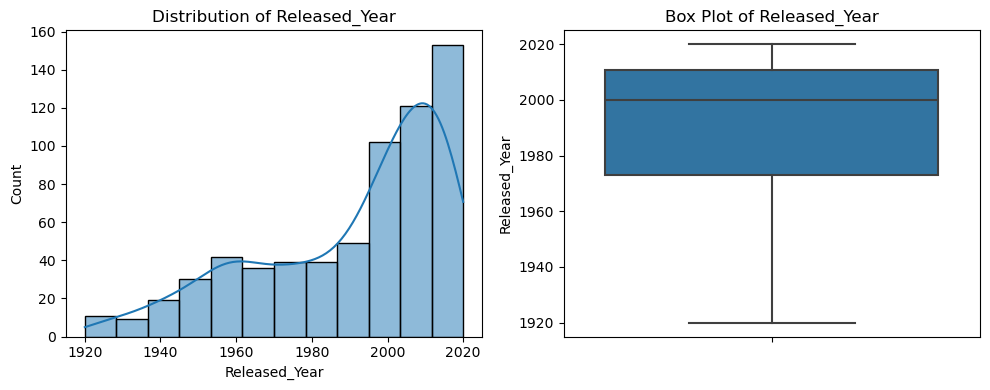

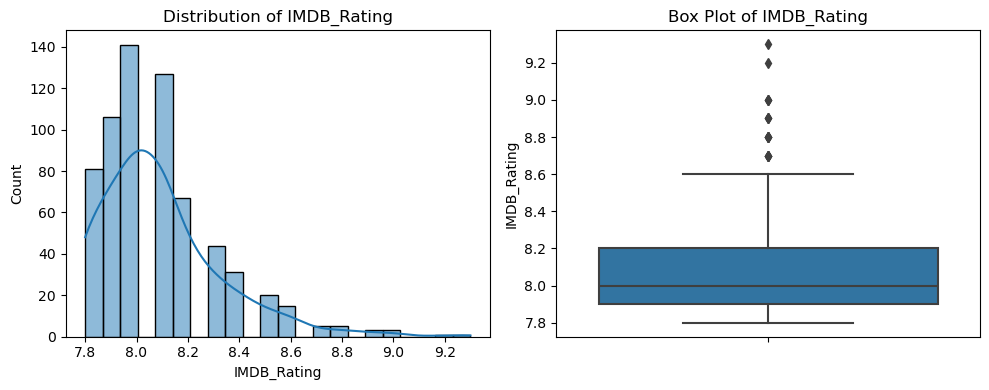

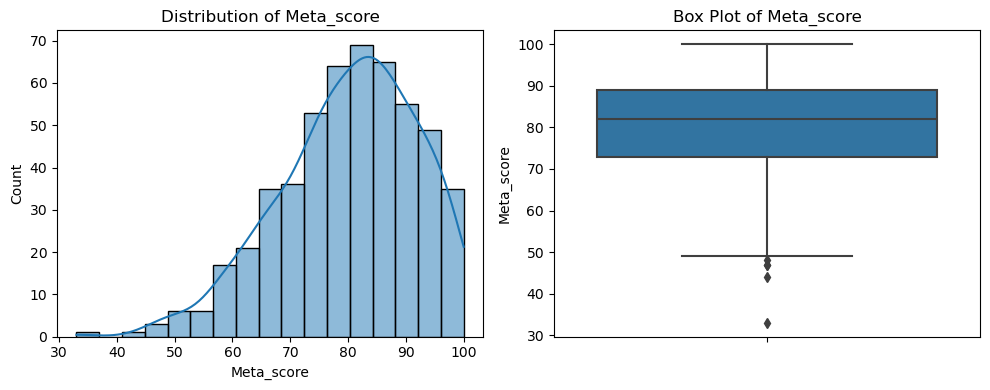

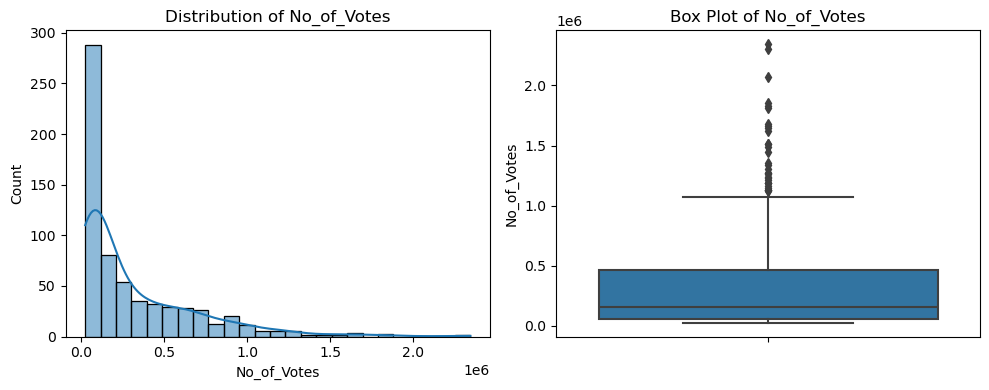

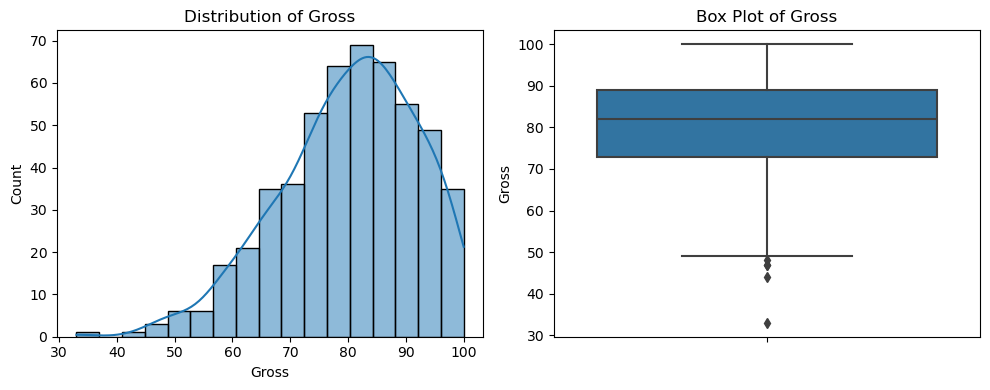

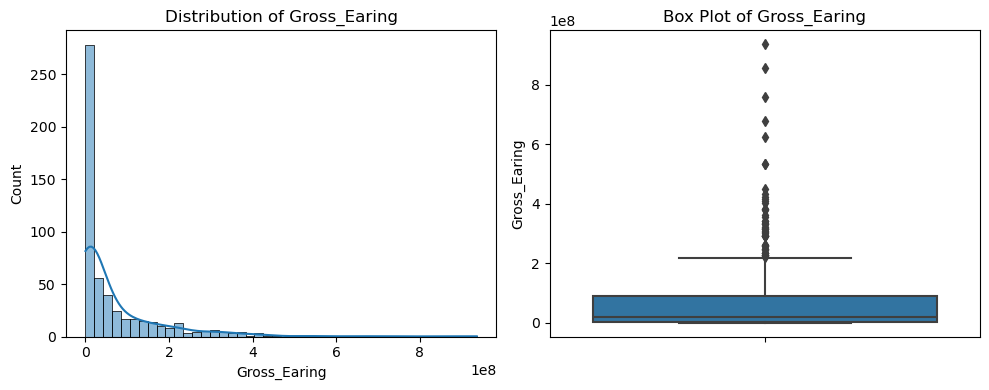


Categorical Columns Summary:

Genre value counts:
Genre
Drama                            57
Drama, Romance                   25
Crime, Drama                     21
Biography, Drama, History        20
Comedy, Drama                    20
                                 ..
Animation, Adventure, Fantasy     1
Comedy, Crime, Sport              1
Comedy, Crime, Romance            1
Adventure, Drama, Musical         1
Adventure, Drama, Romance         1
Name: count, Length: 173, dtype: int64
Genre unique values: 173


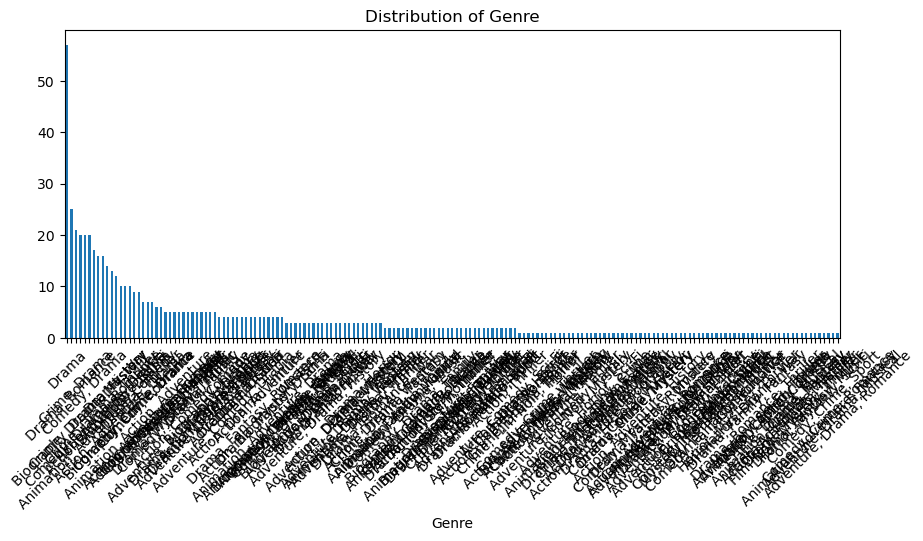


2.2 Bivariate Analysis
------------------------------


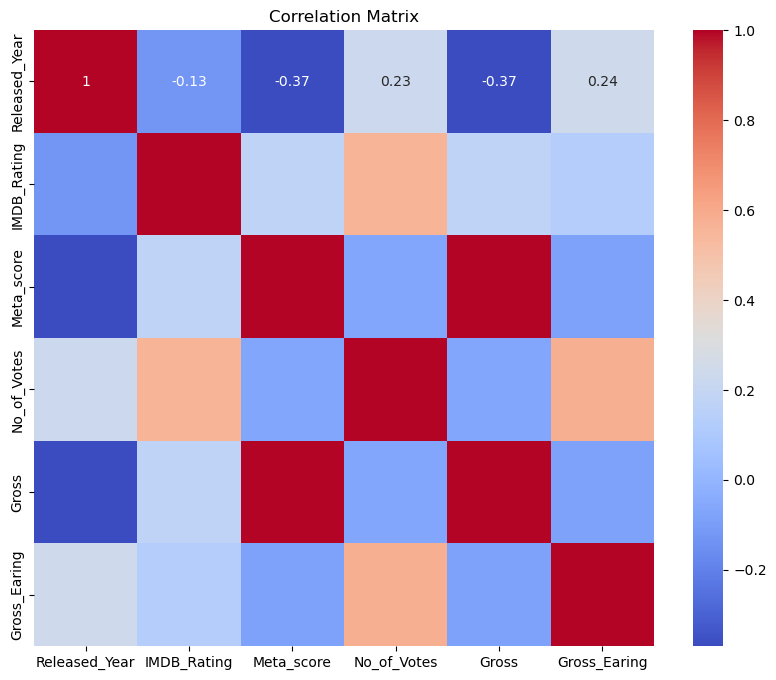


3. Data Preprocessing
--------------------------------------------------

3.1 Handling Missing Values

3.2 Encoding Categorical Variables

3.3 Data Split Information:
Training set shape: (520, 6)
Testing set shape: (130, 6)

4. MLP Training and Evaluation
--------------------------------------------------

4.1 Performing Grid Search for Optimal Parameters...

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}

4.2 Model Accuracy: 0.4000

4.3 Generating Confusion Matrix...


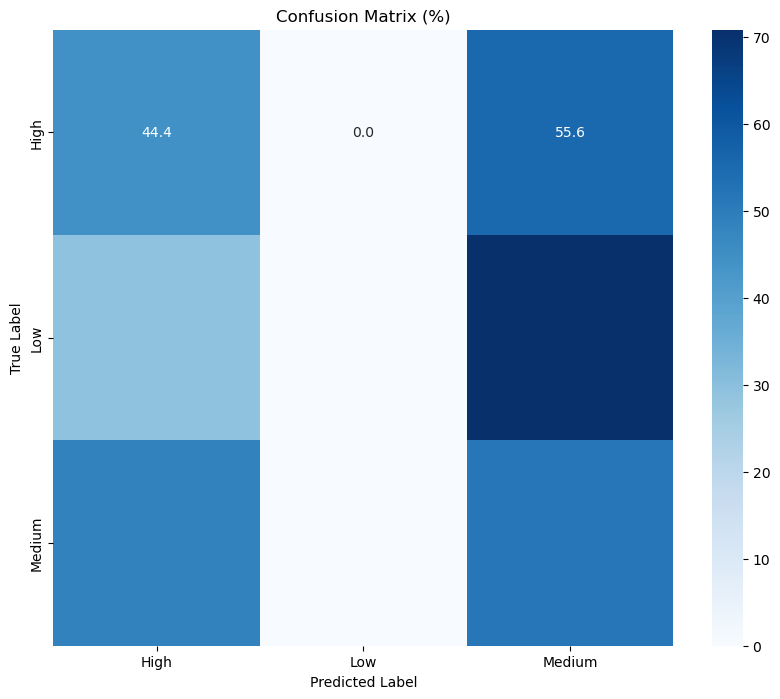


4.4 Classification Report:
              precision    recall  f1-score   support

        High       0.28      0.44      0.34        36
         Low       0.00      0.00      0.00        24
      Medium       0.49      0.51      0.50        70

    accuracy                           0.40       130
   macro avg       0.26      0.32      0.28       130
weighted avg       0.34      0.40      0.37       130


4.5 Generating Learning Curve...


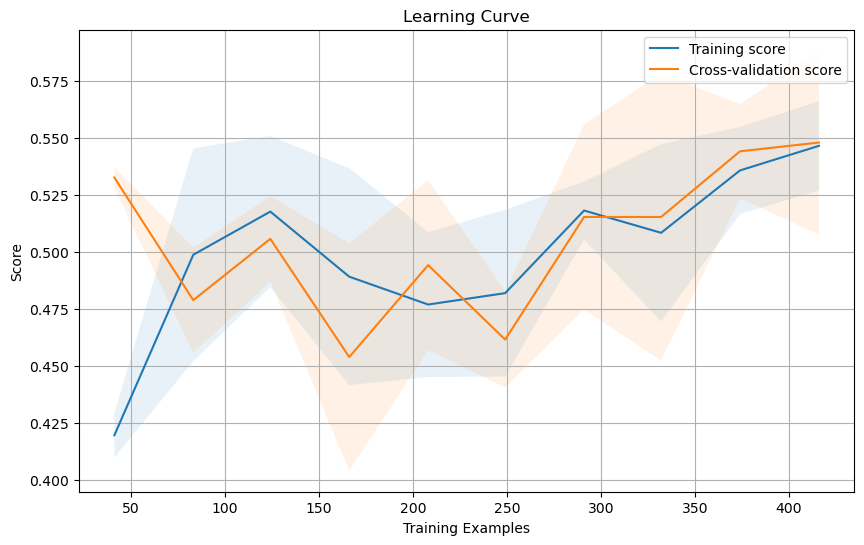


4.6 Analyzing Feature Importance...


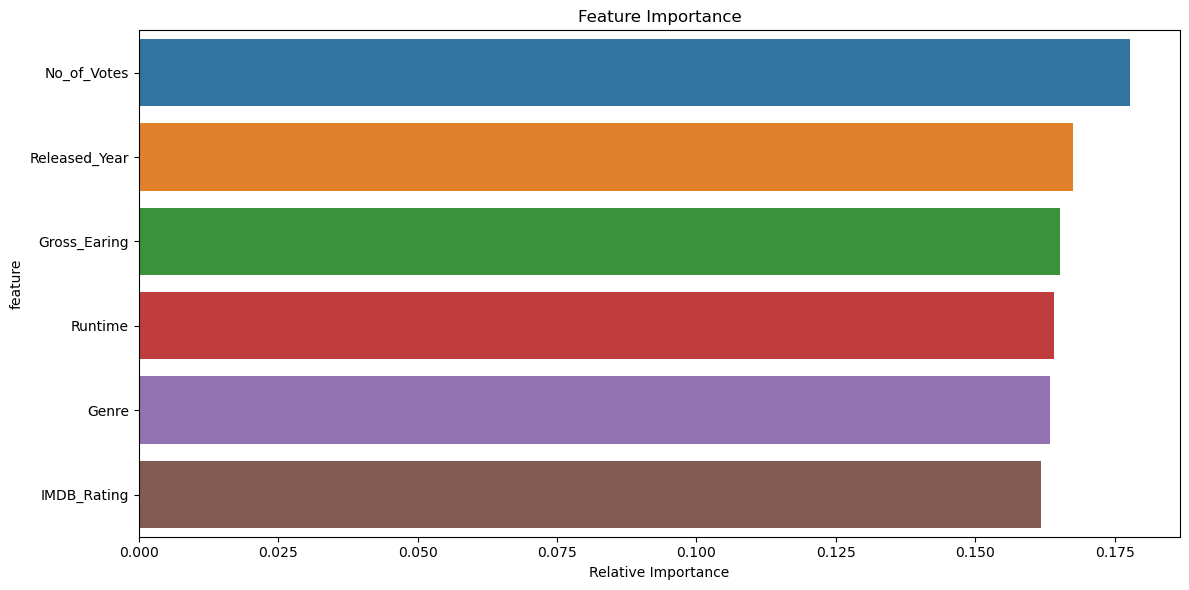

In [65]:
mlp, target_encoder, scaler, label_encoders = run_mlp_analysis(df)